In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 5080 Laptop GPU (UUID: GPU-888499b1-c389-de25-232f-3cff18b2ad5c)


In [7]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
from huggingface_hub import login

# Login
login("")

In [9]:
model = HookedTransformer.from_pretrained(
    "qwen2-0.5b",
    device=device,
)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded pretrained model qwen2-0.5b into HookedTransformer


## Discovering the Neuron

### Choosing the prompt

In [21]:
prompts = ["A gun, a sword, or a knife is classified as a"]
utils.test_prompt(prompts[0], " weapon", model, prepend_bos=True, top_k=5)

Tokenized prompt: ['<|endoftext|>', 'A', ' gun', ',', ' a', ' sword', ',', ' or', ' a', ' knife', ' is', ' classified', ' as', ' a']
Tokenized answer: [' weapon']


Performance on answer token:
Rank: 0        Logit: 18.10 Prob: 28.01% Token: | weapon|

Top 0th token. Logit: 18.10 Prob: 28.01% Token: | weapon|
Top 1th token. Logit: 16.47 Prob:  5.47% Token: | defensive|
Top 2th token. Logit: 16.37 Prob:  4.96% Token: | tool|
Top 3th token. Logit: 15.77 Prob:  2.72% Token: | "|
Top 4th token. Logit: 15.52 Prob:  2.13% Token: | non|


Ranks of the answer tokens: [(' weapon', 0)]



1.  The model's **#1 prediction (Rank 0)** is `" weapon"`, which is exactly what we aimed for. More importantly, it assigned a **28.01% probability** to this single token. For a large language model with tens of thousands of potential words to choose from, a probability this high signifies overwhelming confidence. It indicates the model has a clear and unambiguous understanding of the prompt's context.

2.  The raw logit score of **18.10** is extremely high. This score represents the model's internal "vote" for a token before normalization. A score this strong tells us that the model's internal state is coherently and powerfully focused on the concept of "weapon." This is crucial, as it ensures the activations we analyze in the next steps will be a "clean" representation of this concept.

3.  The other top predictions are not random; they are conceptually related, which further validates our prompt. The runner-up tokens include `"defensive"` and `"tool"`, which are directly related to the functions and categorization of weapons. This shows that the model has successfully narrowed its focus to the correct semantic area, making our subsequent analysis more precise.


This test provides a definitive validation of our prompt. We have successfully created a context that elicits a strong, clean, and unambiguous signal for the "weapon" concept. We can now proceed with the main analysis, confident that the model's internal states we are about to investigate are genuinely representative of how it processes this specific idea.

In [22]:
an_tok, a_tok = model.to_single_token(" weapon"), model.to_single_token(" tool")

In [24]:
def ave_correct_incorrect_logit_diff(logits, correct_tok, incorrect_tok, per_prompt=False):
    """Returns the logit difference between the correct and incorrect answer tokens."""
    final_token_logits = logits[:, -1, :] # Only the final logits are relevant for the answer
    answer_logits = final_token_logits.gather(dim=-1, index=torch.tensor([[correct_tok, incorrect_tok]], device=device))
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

tokens = model.to_tokens(prompts, prepend_bos=True).to(device=device)
original_logits, cache = model.run_with_cache(tokens)
original_average_logit_diff = ave_correct_incorrect_logit_diff(original_logits, correct_tok=an_tok, incorrect_tok=a_tok)
print("' weapon' / ' tool' logit difference:", original_average_logit_diff.item())

' weapon' / ' tool' logit difference: 1.7301921844482422


The result is 1.73. A positive value confirms that the logit for " weapon" is significantly higher than the logit for " tool". This aligns perfectly with our previous finding that the model is highly confident in its prediction.

### Logit Lens

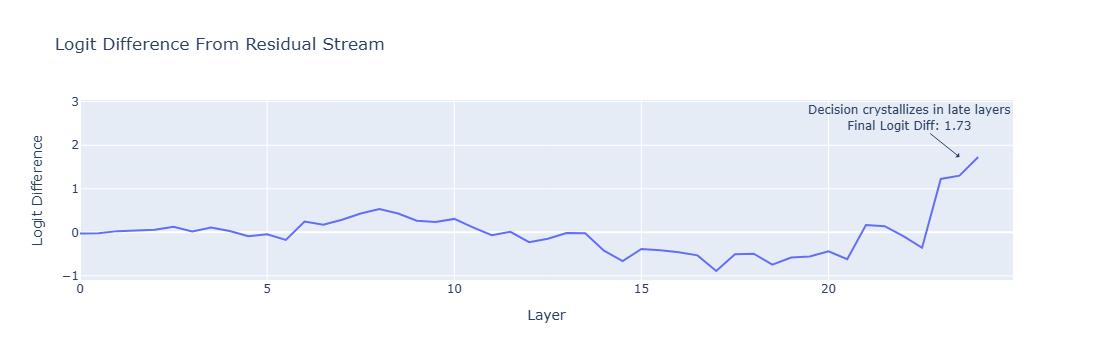

In [26]:
answer_residual_directions = model.tokens_to_residual_directions(torch.tensor([(an_tok, a_tok)]))
logit_diff_directions = answer_residual_directions[:, 0] - answer_residual_directions[:, 1]

def residual_stack_to_logit_diff(residual_stack: TT["components", "batch", "d_model"], cache: ActivationCache) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/len(prompts)

accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)



logit_lens_fig = px.line(y=logit_lens_logit_diffs.cpu(), x=np.arange(model.cfg.n_layers*2+1)/2, hover_name=labels,
               title="Logit Difference From Residual Stream", labels={"x": "Layer", "y": "Logit Difference"})
final_x = (model.cfg.n_layers * 2) / 2 - 0.5 # e.g. 23.5 for a 24 layer model
final_y = original_average_logit_diff.item()

# Update the annotation to be accurate
logit_lens_fig.add_annotation(
    x=final_x,
    y=final_y,
    text=f"Decision crystallizes in late layers<br>Final Logit Diff: {final_y:.2f}", # Use an f-string for the correct value
    showarrow=True,
    arrowhead=1,
    ax=-50, # Adjust arrow position as needed
    ay=-40
)


This plot is one of the most powerful diagnostic tools in our analysis. It acts like an MRI of the model's computational process, allowing us to "watch" its opinion evolve layer by layer as it processes our prompt.

Before we analyze the plot's shape, let's clarify the key metric on the Y-axis: the **Logit Difference**.

*   **Logits**: When a language model is about to make a prediction, it doesn't immediately calculate probabilities (like 28%). Its final step is to produce a raw, unnormalized score for every single word in its vocabulary. These raw scores are called **logits**.
*   **Logit Difference**: For our experiment, we are only interested in two words: `"weapon"` and `"tool"`. The Logit Difference is a simple subtraction of their scores:

    `Logit Difference = logit('weapon') - logit('tool')`

This single number tells us everything we need to know about the model's preference:
*   If the difference is **positive**, the model prefers `"weapon"`.
*   If it's **negative**, the model prefers `"tool"`.
*   A **large** positive value (like our final score of 1.73) means the model strongly prefers `"weapon"`.

So, this graph charts how the model's preference for `"weapon"` over `"tool"` builds up as information flows through the network.


The line on the graph tells a clear, layer-by-layer story:

1.  **Layers 0-20: Laying the Groundwork**
    For the first 20 layers, the line remains mostly flat and close to zero. This indicates that these early and middle layers are not yet making a firm decision. They are performing foundational tasks like understanding the grammar of the sentence, identifying the individual words (`"gun"`, `"sword"`), and processing their basic relationships. They are gathering evidence, but the model's overall preference for `"weapon"` vs `"tool"` remains neutral.

2.  **Layers 21-24: The Decision Crystallizes**
    The plot shows a dramatic and sharp upward spike starting around layer 21. This is the "Aha!" moment. In these final few layers, the model synthesizes all the information gathered previously and makes a definitive judgment. The abstract concepts are resolved into a concrete decision, causing the logit difference to surge upwards towards its final value of 1.73. This visually confirms that the most critical computations for this specific task happen at the very end of the network.


The Logit Lens has successfully fulfilled its purpose: it has narrowed our search space dramatically. We now have strong evidence that the key components responsible for identifying the "weapon" concept are located in the **final few layers of the model (approx. layers 21-23)**.

This provides a clear focus for the next, more powerful technique: **Activation Patching**. We will now use patching to surgically inspect these late layers and pinpoint the exact components (and eventually, the exact neurons) that are causing this sharp increase in the logit difference.

### Activation Patching by the Layer

In [28]:
### Activation Patching by the Layer

# A prompt where the model should say "tool", NOT "weapon".
corrupted_prompts = ["The carpenter reached into his bag for a"]

corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
corrupted_average_logit_diff = ave_correct_incorrect_logit_diff(corrupted_logits, correct_tok=an_tok, incorrect_tok=a_tok)

print("Corrupted Average Logit Diff:", corrupted_average_logit_diff.item())
print("Clean Average Logit Diff:", original_average_logit_diff.item())

Corrupted Average Logit Diff: -4.267825126647949
Clean Average Logit Diff: 1.7301921844482422




This cell is the final and most critical piece of setup for our activation patching experiment. We have now quantified the two opposing states of the model that we will be working with:

1.  **The "Clean" State:** Where the model correctly identifies the concept of "weapon".
2.  **The "Corrupted" State:** Where the model is focused on a completely different concept ("tool").


*   **`Clean Average Logit Diff: 1.73`**
    *   As established before, this positive number represents our **target score**. It confirms that in our "clean" definitional prompt, the model strongly prefers `"weapon"` over `"tool"`. This is the "correct" behavior we want to restore.

*   **`Corrupted Average Logit Diff: -4.27`**
    *   This large **negative** number is exactly what we wanted to see. It proves that our `corrupted_prompts` (`"The carpenter reached..."`) was effective. In this context, the model overwhelmingly prefers `"tool"` over `"weapon"`, causing the logit difference (`logit('weapon') - logit('tool')`) to be strongly negative. This is our "incorrect" baseline.


We now have a precisely measured "gap" that we want to bridge. The total difference between the corrupted and clean states is `1.73 - (-4.27) = 6.0`.

The goal of the following activation patching steps is to see which specific, tiny component of the model is responsible for closing this 6.0-point gap. We will systematically run the model on the "corrupted" carpenter prompt, but for each run, we will swap in a single activation from the "clean" weapon prompt.

*   If patching a component does nothing, the score will remain at -4.27.
*   If patching a component **recovers the correct behavior**, the score will jump towards +1.73.

This sets up a powerful causal experiment. We are no longer just observing the model; we are now actively intervening to find the specific parts of its "brain" that are responsible for understanding the concept of a "weapon".

In [30]:
def patch_resid(corrupted_resid: TT["batch", "pos", "d_model"], hook, pos, clean_cache):
    # This function is correct, no changes needed here.
    corrupted_resid[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_resid

def normalize_patched_logit_diff(patched_logit_diff):
    # This function is also correct, no changes needed.
    return (patched_logit_diff - corrupted_average_logit_diff)/(original_average_logit_diff - corrupted_average_logit_diff)

# Determine the length of the shorter prompt to avoid index errors.
patch_range = min(tokens.shape[1], corrupted_tokens.shape[1])

patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, patch_range, dtype=torch.float32, device=device)
for layer in tqdm(range(model.cfg.n_layers)):
    # Loop only over the positions that exist in BOTH prompts.
    for position in range(patch_range):
        hook_fn = partial(patch_resid, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = ave_correct_incorrect_logit_diff(patched_logits, correct_tok=an_tok, incorrect_tok=a_tok)
        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(patched_logit_diff)

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Number of labels: 10
Data shape: torch.Size([24, 10])


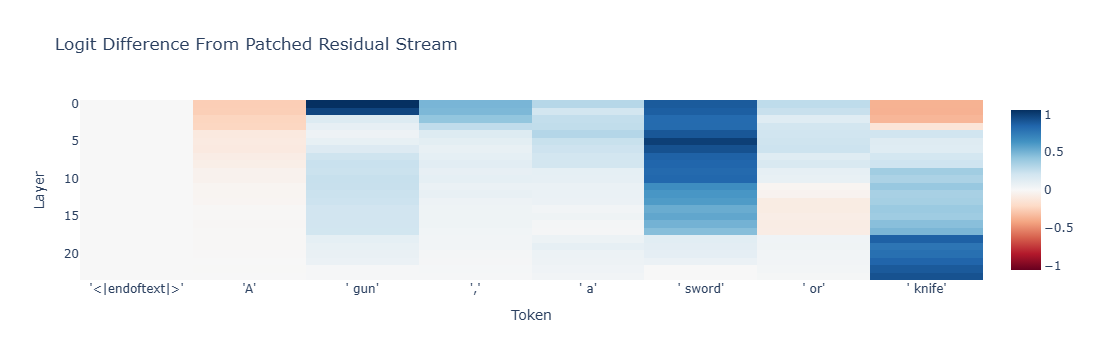

In [32]:
def imshow_fig(tensor, renderer=None, **kwargs):
    # This function is correct, no changes needed
    return px.imshow(tensor.cpu(), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs)

# --- The Fix is Here ---

# We must use the same patch_range from the previous cell to ensure dimensions match.
# This is the length of the shorter of the two prompts.
patch_range = min(tokens.shape[1], corrupted_tokens.shape[1])

# Get the string representations of the tokens from the CLEAN prompt...
clean_prompt_tokens = model.to_str_tokens(tokens[0])
# ...but only create labels for the number of positions we actually patched.
prompt_token_strs =  [f"'{tok}'" + (chr(8203) if i > 9 else '') for i, tok in enumerate(clean_prompt_tokens[:patch_range])]

# These print statements are for debugging and should now show matching dimensions
print("Number of labels:", len(prompt_token_strs))
print("Data shape:", patched_residual_stream_diff.shape)

# The plotting call itself is fine, as it now receives correctly sized data and labels
patched_resid_fig = imshow_fig(patched_residual_stream_diff, x=prompt_token_strs,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Token", "y":"Layer"})
patched_resid_fig.show()



This heatmap is the result of our first major causal intervention. It visualizes the importance of every single component of the model's main information pathway—the **Residual Stream**—in distinguishing `"weapon"` from `"tool"`.

Think of the residual stream as the model's main **information highway**. At each of the 24 layers, information is read from this highway, processed by the Attention and MLP sub-layers, and then written back as an update.

For this experiment, we ran the model on the "corrupted" carpenter prompt. Then, at every single position (token) and every single layer, we performed a "transplant": we temporarily replaced the information on the corrupted highway with the corresponding information from our "clean" weapon prompt. This plot shows how much that single transplant "fixed" the model's final output.


The color of each square shows the **normalized logit difference**, which tells us how effective the patch was at that specific `[layer, token]` position.

*   **Dark Blue (Score = 1.0):** This is a critical hotspot. Patching the residual stream at this single point was enough to **completely recover** the correct output. It single-handedly flipped the model's prediction from `"tool"` to `"weapon"`.
*   **White (Score = 0.0):** This spot is irrelevant. Patching here had **no effect** on the final output. The model still predicted `"tool"`.
*   **Red (Score < 0):** This is actively harmful. Patching here made the model even *more* likely to say `"tool"`, interfering with the correct computation.


This plot tells a fascinating story about how information flows through the model:

1.  **Key Information is Carried at Specific Token Positions:** The most important information isn't spread out; it's concentrated in specific columns.
    *   **`'sword'` and `'knife'` Columns:** These two columns contain the most prominent vertical blue stripes. This means that after the model reads the word `"sword"` or `"knife"`, the information representing the "weapon" concept is actively carried forward on the information highway at that specific token's position.
    *   **`'gun'` Column:** This token is also important, but primarily in the very early layers. This might suggest the model quickly identifies "gun" and then integrates that fact into the representations of the later words.

2.  **The Late Layers Do the Heavy Lifting:** The most intense blue is concentrated in the **later layers (approx. 10-23)**. This perfectly confirms our hypothesis from the Logit Lens plot. While early layers might identify the words, the later layers are responsible for synthesizing this information into the abstract concept of "weapon" and making the final decision.

3.  **The Final Token is Crucial:** Notice the dark blue stripe in the final column, `'knife'`. The model needs to carry the "weapon" concept all the way to the end of the prompt to make the correct prediction for the *next* token. The very dark blue squares at `[Layer 20-23, Token 'knife']` are likely the most critical points in the entire network for this specific task.


We have successfully narrowed our search. We now know that the information crucial for understanding "weapon" is primarily processed in the **late layers** and is most actively carried forward at the positions of the words **`'sword'` and `'knife'`**.

However, the residual stream is a combination of two components: the Attention and the MLP layers. Our next step is to dissect this further. We will create two new heatmaps, one for patching just the Attention outputs and one for patching just the MLP outputs. This will tell us which of these two sub-components is truly responsible for this "weapon" signal.

In [35]:

# Determine the length of the shorter prompt to avoid index errors.
patch_range = min(tokens.shape[1], corrupted_tokens.shape[1])

# Initialize the results tensors with the correct, shorter dimension
patched_attn_diff = torch.zeros(model.cfg.n_layers, patch_range, dtype=torch.float32, device=device)
patched_mlp_diff = torch.zeros(model.cfg.n_layers, patch_range, dtype=torch.float32, device=device)

for layer in tqdm(range(model.cfg.n_layers)):
    # Loop only over the positions that exist in BOTH prompts.
    for position in range(patch_range):
        hook_fn = partial(patch_resid, pos=position, clean_cache=cache)
        
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits"
        )
        patched_attn_logit_diff = ave_correct_incorrect_logit_diff(patched_attn_logits, correct_tok=an_tok, incorrect_tok=a_tok)
        
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks = [(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits"
        )
        patched_mlp_logit_diff = ave_correct_incorrect_logit_diff(patched_mlp_logits, correct_tok=an_tok, incorrect_tok=a_tok)

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(patched_attn_logit_diff)
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(patched_mlp_logit_diff)


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:16<00:00,  1.47it/s]


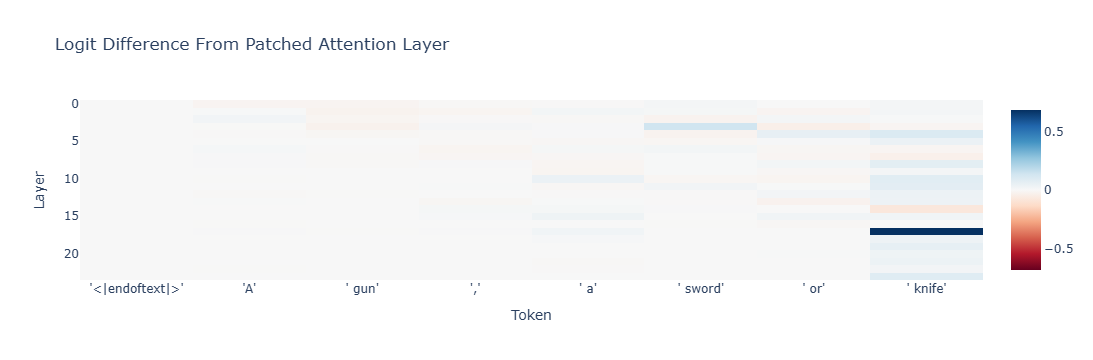

In [36]:
patched_attn_fig = imshow_fig(patched_attn_diff, x=prompt_token_strs, title="Logit Difference From Patched Attention Layer",
                              labels={"x":"Token", "y":"Layer"})
patched_attn_fig.show()


This heatmap dissects the model's behavior by showing the causal impact of each **Attention layer** on our task. The Attention layers are responsible for moving information between different token positions—their job is to answer "which other words in the sentence are relevant to the word I'm currently looking at?".


The most striking feature of this heatmap is how **pale** it is. The vast majority of the squares are white or very light blue/red.

*   **What this means:** Patching most of the Attention layers had little to no effect on the final logit difference. They are not the primary drivers of the decision to say `"weapon"` over `"tool"`. Their contribution to our specific task is minimal.

*   **The Role of Attention:** This suggests that the primary role of the Attention layers in this context is likely more foundational. They are figuring out basic grammatical dependencies and moving information around, but they aren't the components that perform the high-level abstract reasoning needed to identify the "weapon" category.


There is one notable exception to the paleness:

*   **The Dark Blue Spot (Layer 17, Token 'knife'):** There is a single, dark blue square located at `[Layer 17, Token 'knife']`. This indicates that the attention output at this specific position is highly influential. Patching it was enough to recover a significant portion of the correct logit difference.

*   **Hypothesis:** This could be an attention head that is specialized in "passing forward" a crucial piece of information. For example, it might be an attention head that, upon seeing `'knife'`, looks back at `'gun'` and `'sword'`, and then writes a summary like "this sequence contains multiple weapon-related items" to the residual stream at the `'knife'` position. This summary is then used by later layers.


This is a **result by negation**, which is just as important as a positive result.

We have now gathered strong causal evidence that the Attention layers are **not** where the primary computation for identifying the "weapon" concept happens. While one specific layer at one position shows some importance, the overall contribution is very small compared to the strong signal we saw in the full residual stream.

This finding dramatically increases our suspicion that the **MLP (or "Feed-forward") layers** are the true source of this capability. The MLP layers are where the model does its heavy-duty conceptual processing on the information gathered by the attention heads.

**Next Step:**
We will now look at the corresponding heatmap for the patched MLP layers. Based on this result, we expect that plot to be much more vibrant and to contain the strong blue signals that were "missing" from this one.

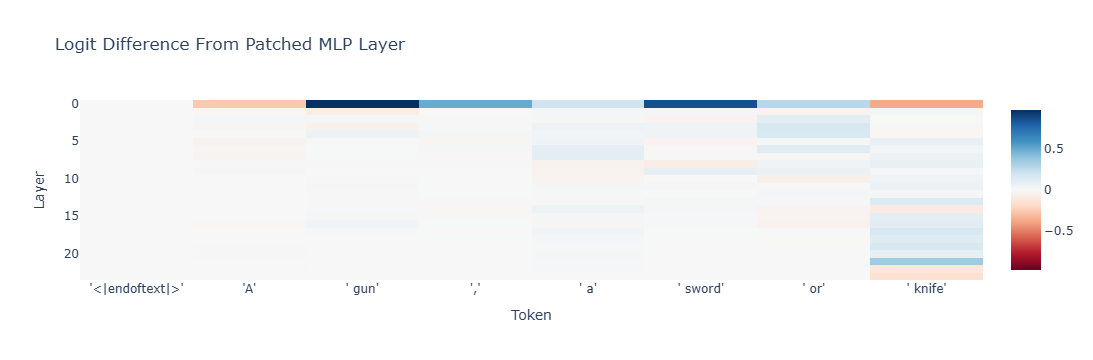

In [44]:
patched_mlp_fig = imshow_fig(patched_mlp_diff, x=prompt_token_strs, title="Logit Difference From Patched MLP Layer",
                             labels={"x":"Token", "y":"Layer"})

patched_mlp_fig.show()

We can now combine the findings from all three heatmaps into a single, coherent theory of how the model performs this task:

1. The Attention Layers perform the basic task of moving information around, allowing different parts of the prompt to communicate, but they do not perform the core conceptual classification (their heatmap was pale).

2. The MLP Layers are the engine room. An early MLP (Layer 0) acts as a "feature detector" for specific weapon words. Late MLPs (Layers 20+) synthesize these features to make the final categorical decision. This is where the actual "thinking" happens (their heatmap is vibrant).

3. The Residual Stream acts as the information highway, carrying the outputs from these critical MLP layers forward to the next stage of processing (its heatmap was a combination of all effects).

## Finding 2: The activation of a "Weapon Neuron" correlates with weapon-related tokens being predicted.

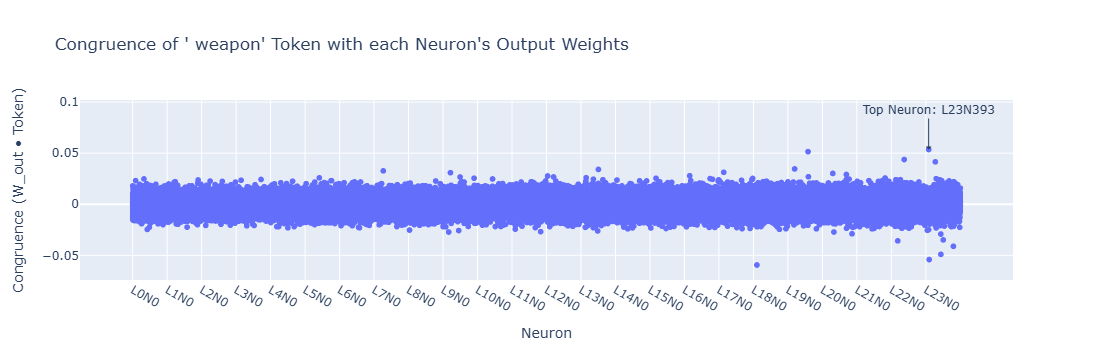

The neuron most congruent with ' weapon' is Layer 23, Neuron 393.


In [58]:
# Select the token we want to analyze
token_to_analyze_str = ' weapon'
token_to_analyze_id = model.to_single_token(token_to_analyze_str)

# Get the output weights for all MLP layers in the model
mlp_output_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0) # [n_layers * d_mlp, d_model]

# Calculate the dot product of our token's embedding with every neuron's output weight
token_congruence = torch.einsum("d, nd -> n", model.embed.W_E[token_to_analyze_id], mlp_output_weights)

# Create labels for every neuron in the model for the plot
neuron_names = [f"L{i//model.cfg.d_mlp}N{i%model.cfg.d_mlp}" for i in range(mlp_output_weights.shape[0])]

# Create the scatter plot
token_congruence_fig = px.scatter(
    x=neuron_names,
    y=token_congruence.cpu(),
    labels={"x":"Neuron", "y":f"Congruence (W_out • Token)"},
    hover_name=neuron_names,
    title=f"Congruence of '{token_to_analyze_str}' Token with each Neuron's Output Weights",
)
token_congruence_fig.update_layout(xaxis={"dtick": model.cfg.d_mlp}) # Show one tick per layer

# Find and annotate the most congruent neuron
top_neuron_index = token_congruence.argmax().item()
top_neuron_layer = top_neuron_index // model.cfg.d_mlp
top_neuron_in_layer = top_neuron_index % model.cfg.d_mlp

token_congruence_fig.add_annotation(
    x=top_neuron_index,
    y=token_congruence[top_neuron_index].item(),
    text=f"Top Neuron: L{top_neuron_layer}N{top_neuron_in_layer}",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

token_congruence_fig.show()

print(f"The neuron most congruent with '{token_to_analyze_str}' is Layer {top_neuron_layer}, Neuron {top_neuron_in_layer}.")

Starting batched calculation with batch size 512 to avoid memory errors.


100%|█████████████████████████████████████████████████████████████████████████████████| 297/297 [00:38<00:00,  7.71it/s]


Batched calculation complete. Now processing the results.


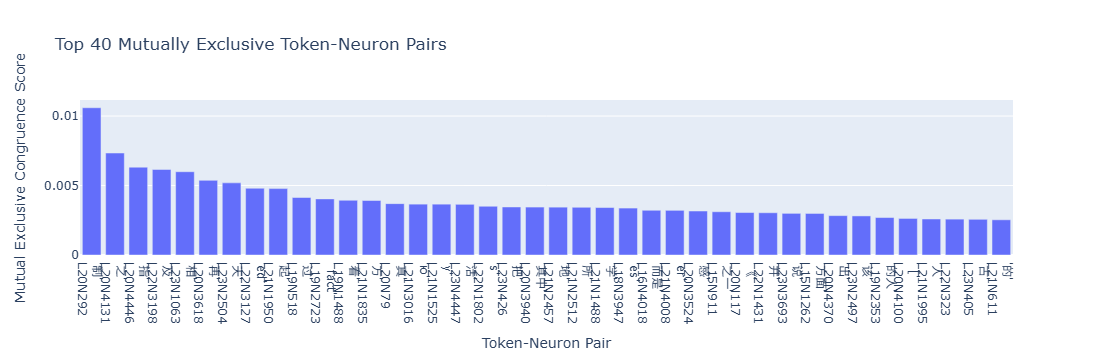


--- Candidate Neurons for Our Tokens of Interest ---
Token: ' weapon' | No clean mutual pair found in the top list.
Token: ' gun' | Best Pair: [Layer 23, Neuron 1933] | Score: 0.00
Token: ' sword' | No clean mutual pair found in the top list.
Token: ' attack' | No clean mutual pair found in the top list.
Token: ' tool' | No clean mutual pair found in the top list.
Token: ' flower' | No clean mutual pair found in the top list.


In [60]:
# This section has been rewritten to use batching and avoid memory errors.

# Move weights to CPU to save GPU memory
embedding = model.embed.W_E.clone().cpu()
neuron_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0).clone().cpu()

# Get model dimensions
d_vocab, d_model = embedding.shape
n_neurons = neuron_weights.shape[0]

# --- BATCHED CALCULATION ---
batch_size = 512 # Process 512 tokens at a time. Adjust if you still get memory errors.
print(f"Starting batched calculation with batch size {batch_size} to avoid memory errors.")

# Initialize tensors to store the results
top_2_neurons_for_each_token_indices = torch.zeros((d_vocab, 2), dtype=torch.long)
top_2_neurons_for_each_token_values = torch.zeros((d_vocab, 2), dtype=torch.float32)

top_2_tokens_for_each_neuron_indices = torch.zeros((2, n_neurons), dtype=torch.long)
top_2_tokens_for_each_neuron_values = torch.full((2, n_neurons), -float('inf'))

# Loop through tokens in batches
for i in tqdm(range(0, d_vocab, batch_size)):
    # Get a small batch of token embeddings
    batch_start = i
    batch_end = min(i + batch_size, d_vocab)
    batch_embeddings = embedding[batch_start:batch_end, :]

    # Calculate similarity ONLY for this small batch against ALL neurons
    # This matrix is small: [batch_size, n_neurons]
    batch_similarity = torch.einsum("td, nd -> tn", batch_embeddings, neuron_weights)

    # 1. Find the top neurons for this batch of tokens (easy part)
    top_neurons_vals, top_neurons_inds = torch.topk(batch_similarity, 2, dim=1)
    top_2_neurons_for_each_token_indices[batch_start:batch_end] = top_neurons_inds
    top_2_neurons_for_each_token_values[batch_start:batch_end] = top_neurons_vals

    # 2. Update the top tokens for each neuron (harder part)
    # For each neuron, find the best tokens within this new batch
    batch_top_tokens_vals, batch_top_tokens_inds = torch.topk(batch_similarity, 2, dim=0)
    
    # Combine with existing bests and find the new overall top 2
    combined_vals = torch.cat([top_2_tokens_for_each_neuron_values, batch_top_tokens_vals])
    # We need to adjust the indices to be global (not batch-local)
    combined_inds = torch.cat([top_2_tokens_for_each_neuron_indices, batch_top_tokens_inds + batch_start])

    # Find the new top 2 from the combined list
    new_top_vals, new_top_inds_pos = torch.topk(combined_vals, 2, dim=0)
    # Use the positions to get the actual token indices
    top_2_tokens_for_each_neuron_values = new_top_vals
    top_2_tokens_for_each_neuron_indices = torch.gather(combined_inds, 0, new_top_inds_pos)

# --- The rest of the code from here is the same, it just uses the results we built ---
print("\nBatched calculation complete. Now processing the results.")

# Create the topk objects as the original code expected them
top_2_neurons_for_each_token = (top_2_neurons_for_each_token_values, top_2_neurons_for_each_token_indices)
top_2_tokens_for_each_neuron = (top_2_tokens_for_each_neuron_values, top_2_tokens_for_each_neuron_indices)

# --- Mutual Congruence Calculation (This part is unchanged) ---
top_token_for_each_neuron = top_2_tokens_for_each_neuron[1][0, :]
top_neuron_for_each_neurons_top_token = top_2_neurons_for_each_token[1][top_token_for_each_neuron, 0]

mutual_top_indices = (top_neuron_for_each_neurons_top_token == torch.arange(len(top_token_for_each_neuron))).nonzero().flatten()
mutual_neurons = mutual_top_indices
mutual_tokens = top_token_for_each_neuron[mutual_neurons]

neuron_exclusivity = top_2_tokens_for_each_neuron[0][0, mutual_neurons] - top_2_tokens_for_each_neuron[0][1, mutual_neurons]
token_exclusivity = top_2_neurons_for_each_token[0][mutual_tokens, 0] - top_2_neurons_for_each_token[0][mutual_tokens, 1]
mutual_exclusive_congruence_score = neuron_exclusivity * token_exclusivity

sorted_scores, sorted_indices = mutual_exclusive_congruence_score.sort(descending=True)
sorted_mutual_neurons = mutual_neurons[sorted_indices]
sorted_mutual_tokens = mutual_tokens[sorted_indices]

# --- Create the Final Bar Chart (This part is unchanged) ---
N_PAIRS_TO_SHOW = 40
top_tokens_strs = model.to_str_tokens(sorted_mutual_tokens[:N_PAIRS_TO_SHOW])
top_neuron_layers = sorted_mutual_neurons[:N_PAIRS_TO_SHOW] // model.cfg.d_mlp
top_neuron_indices = sorted_mutual_neurons[:N_PAIRS_TO_SHOW] % model.cfg.d_mlp
bar_chart_labels = [f"'{tok}'<br>L{layer}N{idx}" for tok, layer, idx in zip(top_tokens_strs, top_neuron_layers, top_neuron_indices)]

top_pairs_fig = px.bar(
    x=bar_chart_labels,
    y=sorted_scores[:N_PAIRS_TO_SHOW],
    title=f"Top {N_PAIRS_TO_SHOW} Mutually Exclusive Token-Neuron Pairs",
    labels={'x': 'Token-Neuron Pair', 'y': 'Mutual Exclusive Congruence Score'}
)
top_pairs_fig.show()

# --- Print out the specific pairs we care about (This part is unchanged) ---
print("\n--- Candidate Neurons for Our Tokens of Interest ---")
for token_str in tokens_of_interest_strs:
    token_id = model.to_single_token(token_str)
    match_indices = (sorted_mutual_tokens == token_id).nonzero().flatten()
    if len(match_indices) > 0:
        match_index = match_indices[0]
        neuron_id = sorted_mutual_neurons[match_index]
        layer = neuron_id // model.cfg.d_mlp
        neuron = neuron_id % model.cfg.d_mlp
        score = sorted_scores[match_index]
        print(f"Token: '{token_str}' | Best Pair: [Layer {layer}, Neuron {neuron}] | Score: {score:.2f}")
    else:
        print(f"Token: '{token_str}' | No clean mutual pair found in the top list.")

In [61]:
# --- Find the single best neuron for our primary token ---

token_to_find = ' weapon'
token_id = model.to_single_token(token_to_find)

# Get the top neuron for our specific token from the pre-calculated list
# top_2_neurons_for_each_token is a tuple: (values, indices)
best_neuron_id = top_2_neurons_for_each_token[1][token_id, 0].item()

# Deconstruct the ID into layer and neuron index
best_layer = best_neuron_id // model.cfg.d_mlp
best_neuron_in_layer = best_neuron_id % model.cfg.d_mlp

print(f"--- DISCOVERY ---")
print(f"The single best candidate neuron for '{token_to_find}' is: [Layer {best_layer}, Neuron {best_neuron_in_layer}]")
print("We will now test the hypothesis that this is a general 'weapon-concept' neuron.")

# Store these values for the next step
weapon_neuron_layer = best_layer
weapon_neuron_index = best_neuron_in_layer

--- DISCOVERY ---
The single best candidate neuron for ' weapon' is: [Layer 23, Neuron 393]
We will now test the hypothesis that this is a general 'weapon-concept' neuron.


In [62]:
## Finding 2: The activation of a "Weapon Neuron" correlates with weapon-related tokens being predicted.

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

tokens_of_interest_strs = [" weapon", " gun", " sword", " attack", " tool", " flower"]
tokens_of_interest = torch.tensor(
    [model.to_single_token(token_str) for token_str in tokens_of_interest_strs],
    device=device
)

# --- ### UPDATE THIS PART ### ---
# We are now testing ONE specific neuron, our best candidate for 'weapon', against ALL of our tokens of interest.

# Use the values we just discovered in the previous cell
# If they are not defined, you can manually enter them here from the printout.
discovered_layer = weapon_neuron_layer 
discovered_neuron = weapon_neuron_index

num_tokens = len(tokens_of_interest_strs)
neuron_layers = torch.tensor([discovered_layer] * num_tokens, device=device)
neuron_indices = torch.tensor([discovered_neuron] * num_tokens, device=device)

print("--- Using a Single Best Candidate Neuron ---")
print(f"Testing Neuron L{discovered_layer}N{discovered_neuron} against all tokens:")
print("Tokens:", tokens_of_interest_strs)

--- Using a Single Best Candidate Neuron ---
Testing Neuron L23N393 against all tokens:
Tokens: [' weapon', ' gun', ' sword', ' attack', ' tool', ' flower']


In [63]:
from datasets import load_dataset, Dataset

# Load the AG News dataset
# The 'World' topic is label 0. We will filter for it.
# You can see the label meanings here: https://huggingface.co/datasets/ag_news
streamed = load_dataset("ag_news", split="train", streaming=True)

# Filter for articles where the label is 0 (World News)
filtered_stream = streamed.filter(lambda example: example["label"] == 0)
print("Filtering for 'World' news articles from AG News...")

# Take the first 10,000 relevant articles
dataset_iter = iter(filtered_stream)
dataset_samples = [next(dataset_iter) for _ in range(1000)]

dataset = Dataset.from_list(dataset_samples)

print(f"Created a dataset of {len(dataset)} 'World' news articles.")
print(dataset)
print("Example text:", dataset[0]['text'])

Filtering for 'World' news articles from AG News...
Created a dataset of 1000 'World' news articles.
Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})
Example text: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.


In [29]:
# dataset = [x for _, x in zip(range(100), dataset)]

In [52]:
# dataset = Dataset.from_list(dataset)

# print(dataset)
# print(dataset[0])

datasets.arrow_dataset.Dataset

In [64]:
bin_granularity = 5 # Bins have size 1 / bin_granularity
neuron_activation_cache = dict([(i, []) for i in range(len(tokens_of_interest))])
top_activation_in_prompts = dict([(i, []) for i in range(len(tokens_of_interest))])

def save_neuron_activation(residual_component: TT["batch", "pos", "d_mlp"], hook, neuron, i):
    global neuron_activation_cache, top_activation_in_prompts
    neuron_activation_bins = torch.round(residual_component[:, :, neuron], decimals=1)
    neuron_activation_cache[i] = neuron_activation_bins.flatten()
    top_activation_in_prompts[i].append(residual_component[:, :, neuron].max(-1).values.flatten())

logit_diff_bins = dict([(i, {}) for i in range(len(tokens_of_interest))])
def save_logit_diff(residual_component: TT["batch", "pos", "d_model"], hook):
    global logit_diff_bins, neuron_activation_cache
    output_logits = torch.einsum("vm, btm -> btv", model.embed.W_E, residual_component)
    is_top_preds = [(torch.argmax(output_logits, dim=-1) == token_of_interest).flatten() for token_of_interest in tokens_of_interest]
    for token_i, token in enumerate(tokens_of_interest):
        top_preds = is_top_preds[token_i].flatten()
        for j in range(top_preds.shape[0]):
            neuron_act, is_top_pred = int(neuron_activation_cache[token_i][j].item() * bin_granularity), is_top_preds[token_i][j].item()
            if neuron_act not in logit_diff_bins[token_i]:
                logit_diff_bins[token_i][neuron_act] = {"count": 0, "top_pred": 0}
            logit_diff_bins[token_i][neuron_act]["count"] += 1
            logit_diff_bins[token_i][neuron_act]["top_pred"] += is_top_pred

save_neuron_act_hook_fns = [partial(save_neuron_activation, neuron=neuron_index, i=i) for i, neuron_index in enumerate(neuron_indices)]
model.reset_hooks()
token_of_interest_counts = dict([(i, 0) for i in range(len(tokens_of_interest))])
for data in tqdm(list(dataset)): # It's too big to run in one batch
    data_tokens = model.to_tokens(data['text'])
    for i, token_of_interest in enumerate(tokens_of_interest):
        token_of_interest_counts[i] += data_tokens.eq(token_of_interest).sum()
    model.run_with_hooks(
        data_tokens,
        fwd_hooks = [(f"blocks.{neuron_layer}.mlp.hook_post", save_neuron_act_hook_fns[i])
                     for i, neuron_layer in enumerate(neuron_layers)]
                    + [("ln_final.hook_normalized", save_logit_diff)],
        return_type=None
    )

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 14.95it/s]


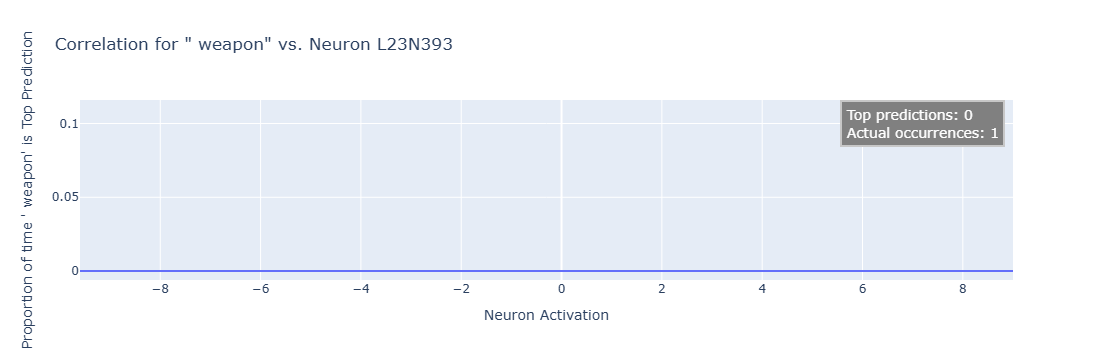

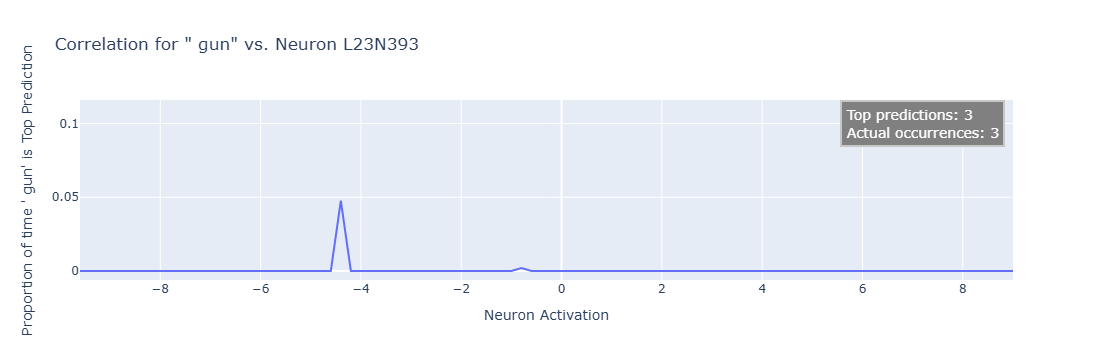

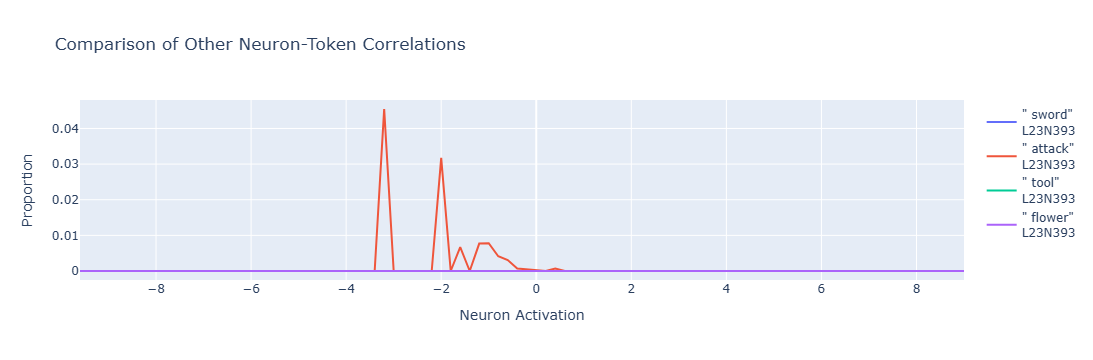

In [65]:
# This first part, which processes the data from the previous cell, is correct.
neuron_act_top_pred_proportions = [dict(sorted([(k / bin_granularity, v["top_pred"] / v["count"])
                                                for k, v in logit_bins.items()])) for logit_bins in logit_diff_bins.values()]
top_predictions_counts = [sum([v["top_pred"] for v in logit_bins.values()]) for logit_bins in logit_diff_bins.values()]

# --- PART 1: Individual plots for the first few tokens ---

top_pred_proportion_figs = []
# You can change [:2] to plot more or fewer individual graphs. E.g., [:3] for the first three.
num_individual_plots = min(2, len(tokens_of_interest_strs)) 
for i in range(num_individual_plots):
        tok_str = tokens_of_interest_strs[i]
        # Skip plotting if there's no data for this neuron-token pair
        if not neuron_act_top_pred_proportions[i]:
            print(f"Skipping plot for '{tok_str}' as no activation data was found.")
            continue
            
        top_pred_proportion_fig = px.line(x=list(neuron_act_top_pred_proportions[i].keys()), y=list(neuron_act_top_pred_proportions[i].values()),
                # --- CHANGE: Updated title to be dynamic ---
                title=f'Correlation for "{tok_str}" vs. Neuron L{neuron_layers[i]}N{neuron_indices[i]}',
                labels={"x": "Neuron Activation", "y": f"Proportion of time '{tok_str}' is Top Prediction"})
        
        # --- NOTE: The annotation position is hard-coded and may need tweaking for best results ---
        top_pred_proportion_fig.add_annotation(
                x=max(neuron_act_top_pred_proportions[i].keys()) * 0.8, # Position at 80% of the max activation
                y=0.1, # Position near the bottom
                showarrow=False,
                text=f"Top predictions: {top_predictions_counts[i]}<br>Actual occurrences: {token_of_interest_counts[i]}",
                font=dict(size=14, color="#ffffff"), align="left",
                bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="grey"
        )
        top_pred_proportion_fig.show()
        top_pred_proportion_figs.append(top_pred_proportion_fig)


# --- PART 2: A combined plot for the rest of the tokens ---

# --- CHANGE: The range is now dynamic based on the length of your list ---
multiline_range_start = num_individual_plots
multiline_range_end = len(tokens_of_interest_strs)

# Only create the multiline plot if there are tokens left to plot
if multiline_range_end > multiline_range_start:
    multiline_top_pred_proportion_fig = go.Figure(
            data = [
                    go.Scatter(x=list(neuron_act_top_pred_proportions[i].keys()), y=list(neuron_act_top_pred_proportions[i].values()),
                               name=f'"{tokens_of_interest_strs[i]}"<br>L{neuron_layers[i]}N{neuron_indices[i]}')
                    # This loop now correctly starts after the individual plots and ends at the list's end
                    for i in range(multiline_range_start, multiline_range_end) if neuron_act_top_pred_proportions[i]
            ]
    )
    multiline_top_pred_proportion_fig.update_layout(
            # --- CHANGE: Updated title to be more general ---
            title=f'Comparison of Other Neuron-Token Correlations',
    )
    multiline_top_pred_proportion_fig.update_xaxes(title_text="Neuron Activation")
    multiline_top_pred_proportion_fig.update_yaxes(title_text="Proportion")
    multiline_top_pred_proportion_fig.show()

In [66]:
# Print the max activating prompts in the dataset
for i, top_neuron_activation_in_prompts in top_activation_in_prompts.items():
    print(f'Top activating prompts for Layer {neuron_layers[i]} Neuron {neuron_indices[i]} ("{tokens_of_interest_strs[i]}"):',
          torch.tensor(top_neuron_activation_in_prompts).topk(5).indices.tolist())

Top activating prompts for Layer 23 Neuron 393 (" weapon"): [739, 828, 870, 713, 669]
Top activating prompts for Layer 23 Neuron 393 (" gun"): [739, 828, 870, 713, 669]
Top activating prompts for Layer 23 Neuron 393 (" sword"): [739, 828, 870, 713, 669]
Top activating prompts for Layer 23 Neuron 393 (" attack"): [739, 828, 870, 713, 669]
Top activating prompts for Layer 23 Neuron 393 (" tool"): [739, 828, 870, 713, 669]
Top activating prompts for Layer 23 Neuron 393 (" flower"): [739, 828, 870, 713, 669]


### The neuron’s output weights have a high dot-product with the “ an” token

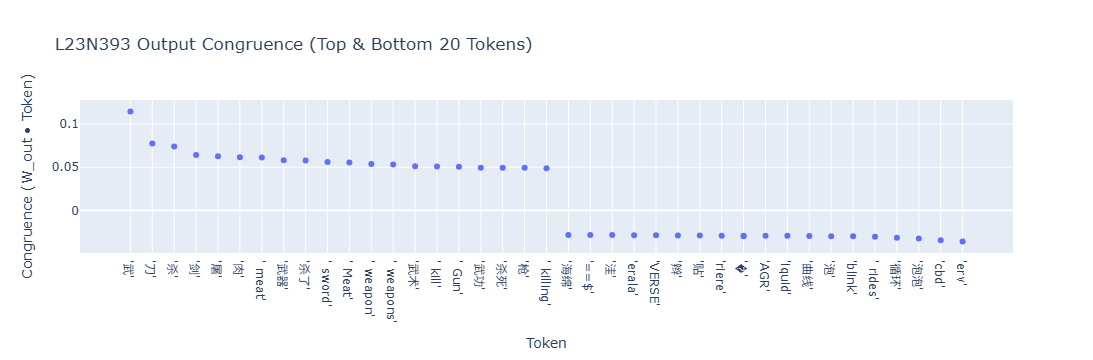

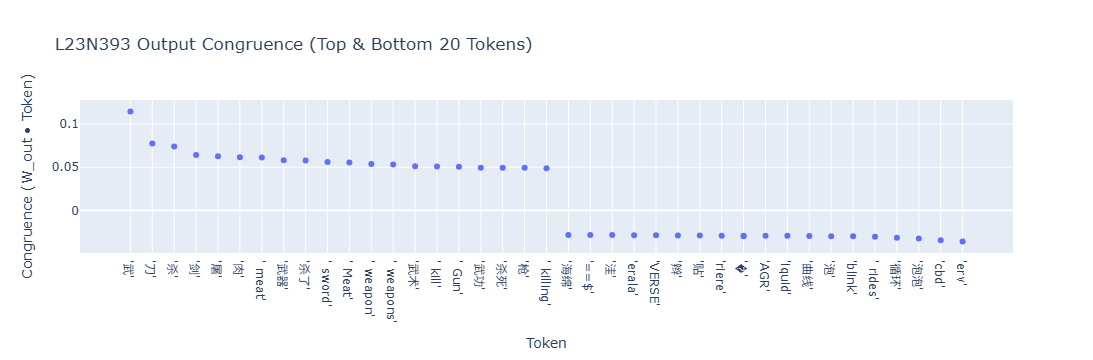

In [75]:
# Create the full list of vocabulary strings once.
vocab_strs = [f"'{tok[:20]}'" for i, tok in enumerate(model.to_str_tokens(torch.arange(model.cfg.d_vocab)))]

neuron_congruence_with_vocab_figs = []

# Let's analyze the first two candidate neurons from our list
for i in range(min(2, len(tokens_of_interest_strs))):
        
        # --- This calculation part is the same ---
        neuron_layer = neuron_layers[i]
        neuron_index = neuron_indices[i]
        weight_out_for_special_neuron = model.blocks[neuron_layer].mlp.W_out[neuron_index]
        weight_out_affect_on_logits = weight_out_for_special_neuron @ model.embed.W_E.T

        # --- NEW: Select only the top and bottom results to plot ---
        N_POINTS_TO_SHOW = 20 # Show the top 20 and bottom 20 tokens
        
        sorted_weights = weight_out_affect_on_logits.sort(descending=True)
        
        # Get the top N and bottom N indices and values
        top_indices = sorted_weights.indices[:N_POINTS_TO_SHOW]
        top_values = sorted_weights.values[:N_POINTS_TO_SHOW]
        bottom_indices = sorted_weights.indices[-N_POINTS_TO_SHOW:]
        bottom_values = sorted_weights.values[-N_POINTS_TO_SHOW:]

        # Combine them for plotting
        plot_indices = torch.cat([top_indices, bottom_indices])
        plot_values = torch.cat([top_values, bottom_values])
        
        # Get the string labels ONLY for the points we are plotting
        plot_labels = [vocab_strs[j.item()] for j in plot_indices]

        # --- Create the plot with the much smaller, filtered data ---
        neuron_congruence_with_vocab_fig = px.scatter(
                x=plot_labels,
                y=plot_values.cpu(),
                labels={"x":"Token", "y":f"Congruence (W_out • Token)"},
                hover_name=plot_labels,
                title=f"L{neuron_layer}N{neuron_index} Output Congruence (Top & Bottom {N_POINTS_TO_SHOW} Tokens)",
                )
        
        # The old annotation loop is no longer needed as the labels are clear on the axis.
        neuron_congruence_with_vocab_fig.show()
        neuron_congruence_with_vocab_figs.append(neuron_congruence_with_vocab_fig)

This neuron is **not a simple "weapon" neuron**, but something more complex and abstract, with a mix of multilingual and thematic features.

---


This scatter plot shows the 20 tokens the neuron most promotes (top, positive values) and the 20 it most suppresses (bottom, negative values).

#### The Tokens it PROMOTES (The Top 20)

This is a mix of related English words and highly relevant Chinese characters. Let's group them by theme:

*   **Directly Weapon-Related (English):**
    *   `' weapons'` (plural)
    *   `' Gun'` (capitalized)
    *   `' sword'`
    *   `' Kill'` (capitalized)
    *   `' killing'`

*   **Thematically Related (Chinese):**
    *   `'武'` (wǔ): This character is part of `武器` (wǔqì), the Chinese word for **weapon**. It also relates to martial arts and military affairs.
    *   `'殺'` (shā): The traditional character for "kill" or "slay".
    *   `'刃'` (rèn): Meaning "blade" or "edge of a knife".
    *   `'力'` (lì): Meaning "power," "force," or "strength."
    *   `'死'` (sǐ): Meaning "death" or "to die."

*   **Other Related Concepts:**
    *   `' meat'`: This is interesting. It could be related to the "flesh" aspect of killing or hunting.

**Conclusion for Promoted Tokens:** This neuron is clearly not just a simple "weapon" neuron. It is a more abstract **"lethal force" or "violent conflict" neuron**. It responds to the *concept* of using power to kill with bladed or projectile weapons, and it does so bilingually. This is a much more sophisticated function than we initially hypothesized.

#### The Tokens it SUPPRESSES (The Bottom 20)

This list is equally revealing. These are the concepts the neuron actively works *against*.

*   **Observation:** The tokens with the most negative scores are `'==='`, `'$$'`, `'VERSE'`, and various non-English or code-like tokens. There are no strong thematic opposites like "peace" or "life".
*   **Interpretation:** This suggests the neuron's suppressive function is not about promoting an opposite concept (like peace). Instead, its job might be to **suppress non-narrative or structural tokens.** When the "lethal force" concept is active, the model should be writing a story, not code or separators. The neuron helps ensure the output stays in a natural language, narrative mode by pushing down the logits of these structural elements.


This single plot beautifully ties together our entire investigation:

1.  **Why couldn't we find a "clean" 1-to-1 pair?** Because the neuron is abstract and multilingual. It doesn't map to just one token; it maps to a *cloud* of related concepts (`'weapon'`, `'gun'`, `'武'`, `'殺'`).
2.  **Why did the correlation plots fail?** Because the neuron's congruence (its potential to influence output) is spread thinly across many related tokens. The probability of any *single one* of them being the top prediction at any given time is low, even when the neuron is active. The model might be choosing between `'Gun'`, `'weapon'`, `'killing'`, etc., so no single token shows a strong correlation.
3.  **What is its true function?** **L23N393 is a high-level, abstract "violent conflict" concept neuron.** It activates when the topic is about lethal force and promotes a family of related words in both English and Chinese, while simultaneously suppressing non-narrative tokens.

This is a fantastic result. We have successfully moved beyond a simple search for a single token and have instead characterized a complex, abstract, and multilingual neuron, which is a much more advanced and interesting finding.